# ZFEL SASE

Basic example of a SASE simulation.

In [1]:
import sys
sys.path.append('/Users/nneveu/github/zfel')
# (optional) installation
# !pip install git+https://github.com/slaclab/zfel.git@devel

In [2]:
from zfel import sase1d
import zfel.plot

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Input 

In [44]:
# gauss de 0.009156671910200503
# dcns de 0.01845078607133632
# gauss betax -4.980558380509362e-09
# dcns betax -5.287191800322559e-08
# gauss ave current 851.6564516106191
# gauss ave current 8094551537732.525

In [62]:
gauss_sase_input = dict(
    npart   = 512,                       # n-macro-particles per bucket 
    s_steps = 200,                      # n-sample points along bunch length
    z_steps = 200,                      # n-sample points along undulator
    energy  = 3.98e9,                # electron energy [eV]
    eSpread = 0.005,                       # relative rms energy spread [1]
    emitN   = 0.36e-6,                    # normalized transverse emittance [m-rad]
    currentMax = 1590,                   # peak current [Ampere]
    beta = 26,                          # mean beta [meter]
    unduPeriod = 0.039,                 # undulator period [meter]
    unduK = 3.5 ,          # undulator parameter, K [1], array could taper. 
    unduL = 70,                         # length of undulator [meter]
    radWavelength=None,                 # Will calculate based on resonance condition for unduK[0]
    random_seed=31,                     # for reproducibility
    particle_position=None, #np.genfromtxt('./Inputs/particle_position.csv', delimiter=',') # or None,
    hist_rule='square-root',             # 'square-root' or 'sturges' or 'rice-rule' or 'self-design', number \
                                       #  of intervals to generate the histogram of eta value in a bucket
    iopt='sase',
    P0 = 0                            # small seed input power [W]
)

In [63]:
dcns_sase_input = dict(
    npart   = 512,                       # n-macro-particles per bucket 
    s_steps = 200,                      # n-sample points along bunch length
    z_steps = 200,                      # n-sample points along undulator
    energy  = 4e9,                # electron energy [eV]
    eSpread = 0.01,                       # relative rms energy spread [1]
    emitN   = 0.35e-6,                    # normalized transverse emittance [m-rad]
    currentMax = 1960,                   # peak current [Ampere]
    beta = 26,                          # mean beta [meter]
    unduPeriod = 0.039,                 # undulator period [meter]
    unduK = 3.5 ,          # undulator parameter, K [1], array could taper. 
    unduL = 70,                         # length of undulator [meter]
    radWavelength=None,                 # Will calculate based on resonance condition for unduK[0]
    random_seed=31,                     # for reproducibility
    particle_position=None, #np.genfromtxt('./Inputs/particle_position.csv', delimiter=',') # or None,
    hist_rule='square-root',             # 'square-root' or 'sturges' or 'rice-rule' or 'self-design', number \
                                       #  of intervals to generate the histogram of eta value in a bucket
    iopt='sase',
    P0 = 0                            # small seed input power [W]
)

## Intermediate parameters 

These are used internally

In [64]:
gauss_params = sase1d.params_calc(**gauss_sase_input)
gauss_params.keys()

dict_keys(['unduJJ', 'gamma0', 'sigmaX2', 'kappa_1', 'density', 'Kai', 'ku', 'resWavelength', 'Pbeam', 'coopLength', 'z0', 'delt', 'dels', 'E02', 'gbar', 'delg', 'Ns', 'deta', 'rho'])

In [65]:
dcns_params = sase1d.params_calc(**dcns_sase_input)
dcns_params.keys()

dict_keys(['unduJJ', 'gamma0', 'sigmaX2', 'kappa_1', 'density', 'Kai', 'ku', 'resWavelength', 'Pbeam', 'coopLength', 'z0', 'delt', 'dels', 'E02', 'gbar', 'delg', 'Ns', 'deta', 'rho'])

## Run

In [66]:
%%time
goutput = sase1d.sase(gauss_sase_input)

CPU times: user 5.19 s, sys: 21.4 ms, total: 5.21 s
Wall time: 5.23 s


In [67]:
%%time
doutput = sase1d.sase(dcns_sase_input)

CPU times: user 4.75 s, sys: 15.3 ms, total: 4.76 s
Wall time: 4.77 s


In [68]:
output.keys()

dict_keys(['Er', 'Ei', 'thet_final', 'eta_final', 'theta_final_slice_history', 'eta_final_slice_history', 'power_s', 'power_z', 'spectrum', 'params', 's', 'z', 'bunchLength', 'bunch_steps', 'freq'])

## Plot output

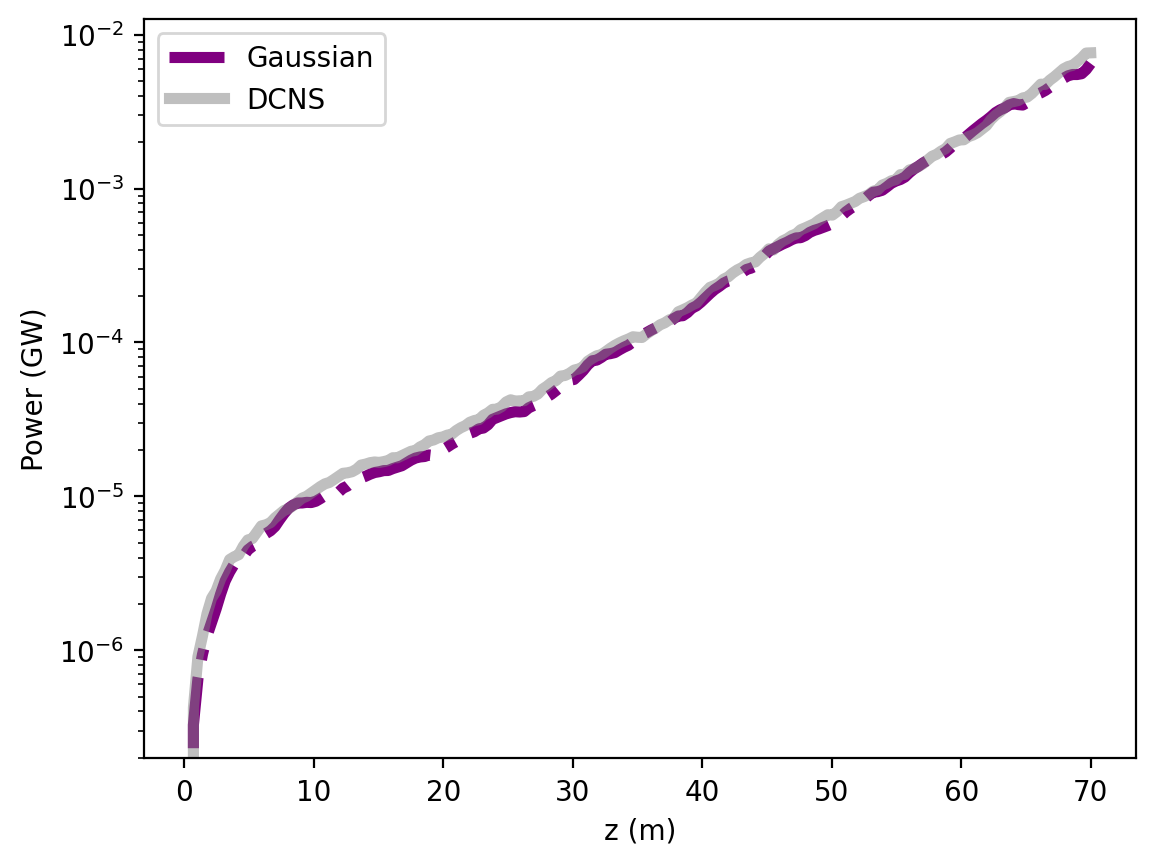

In [83]:
plt.ylabel('Power (GW)')
plt.xlabel('z (m)')
plt.plot(goutput['z'], goutput['power_z']/1e9, label='Gaussian', linestyle='-.', linewidth=4, color='purple')
plt.plot(doutput['z'], doutput['power_z']/1e9, label='DCNS', linestyle='-', linewidth=4, alpha=0.5, color='grey')
plt.yscale("log")
# plt.grid()
plt.legend()
plt.savefig('fel_power.pdf', dpi=250)

In [17]:
# Power evolution. z vs slice
#plt.imshow( (output['Er']**2 + output['Ei']**2).T, origin='lower')

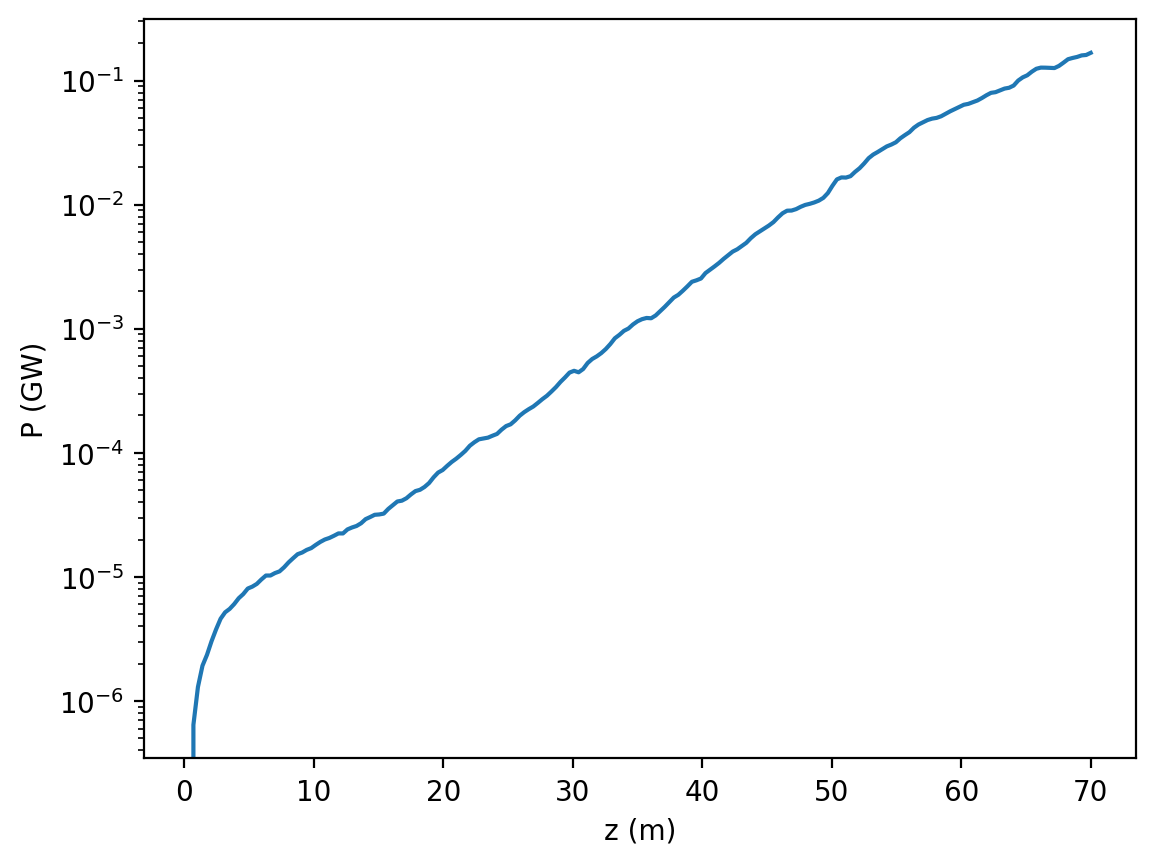

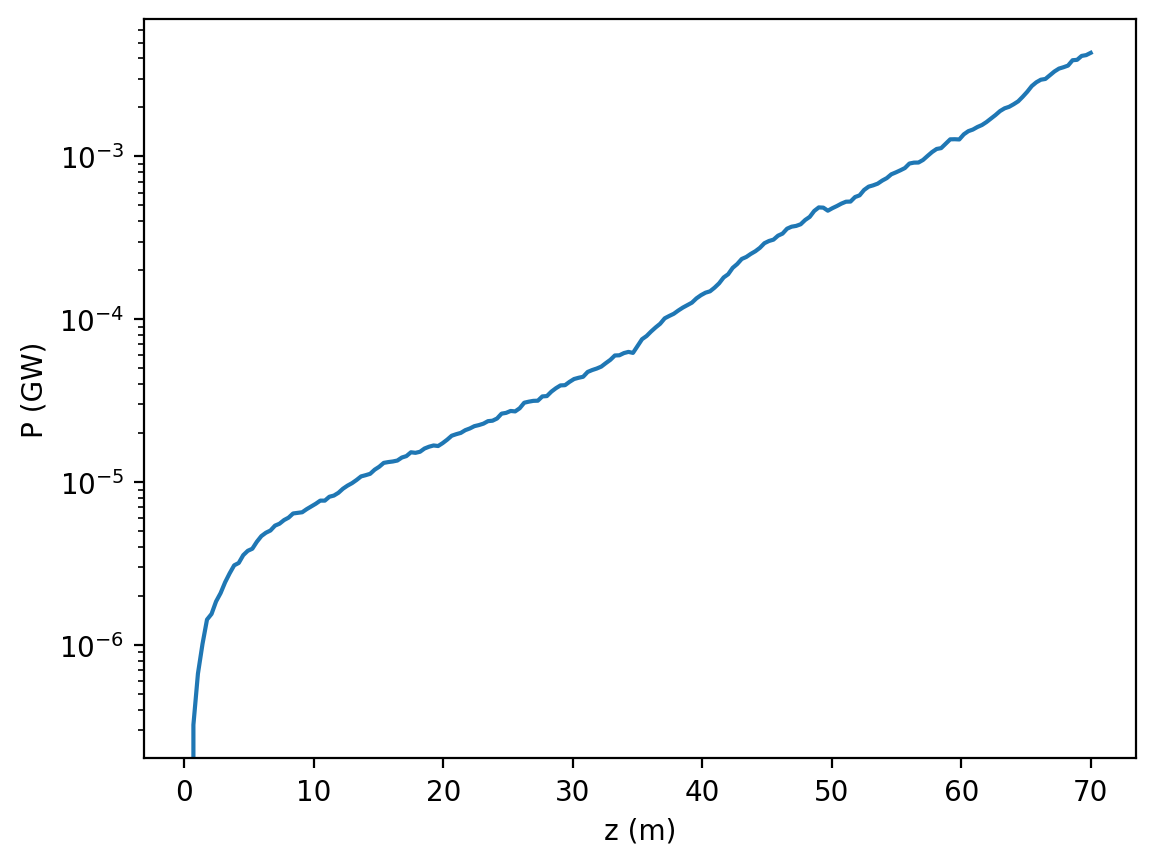

In [37]:
zfel.plot.plot_log_power_z(goutput)
zfel.plot.plot_log_power_z(doutput)
plt.savefig('fel_hold.pdf', dpi=250)

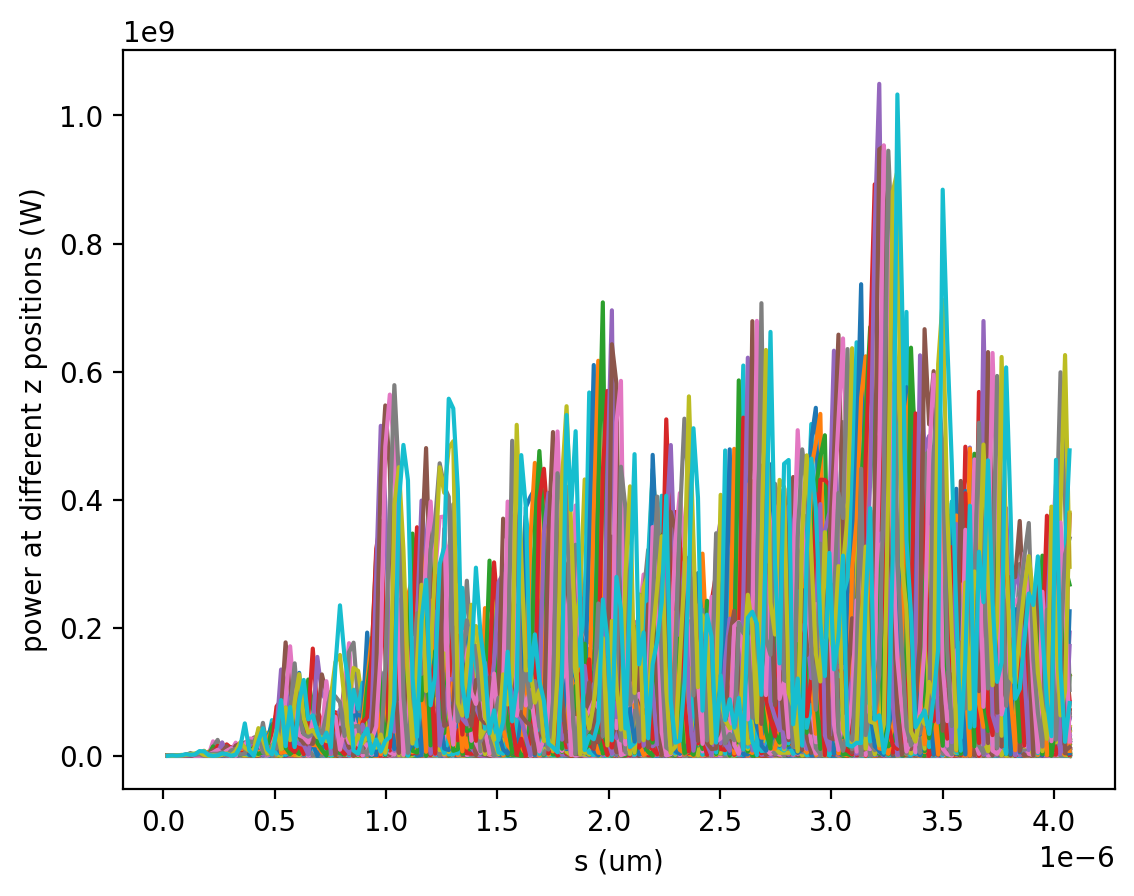

In [29]:
zfel.plot.plot_power_s(output)

Text(0, 0.5, 'spectrum (W/?)')

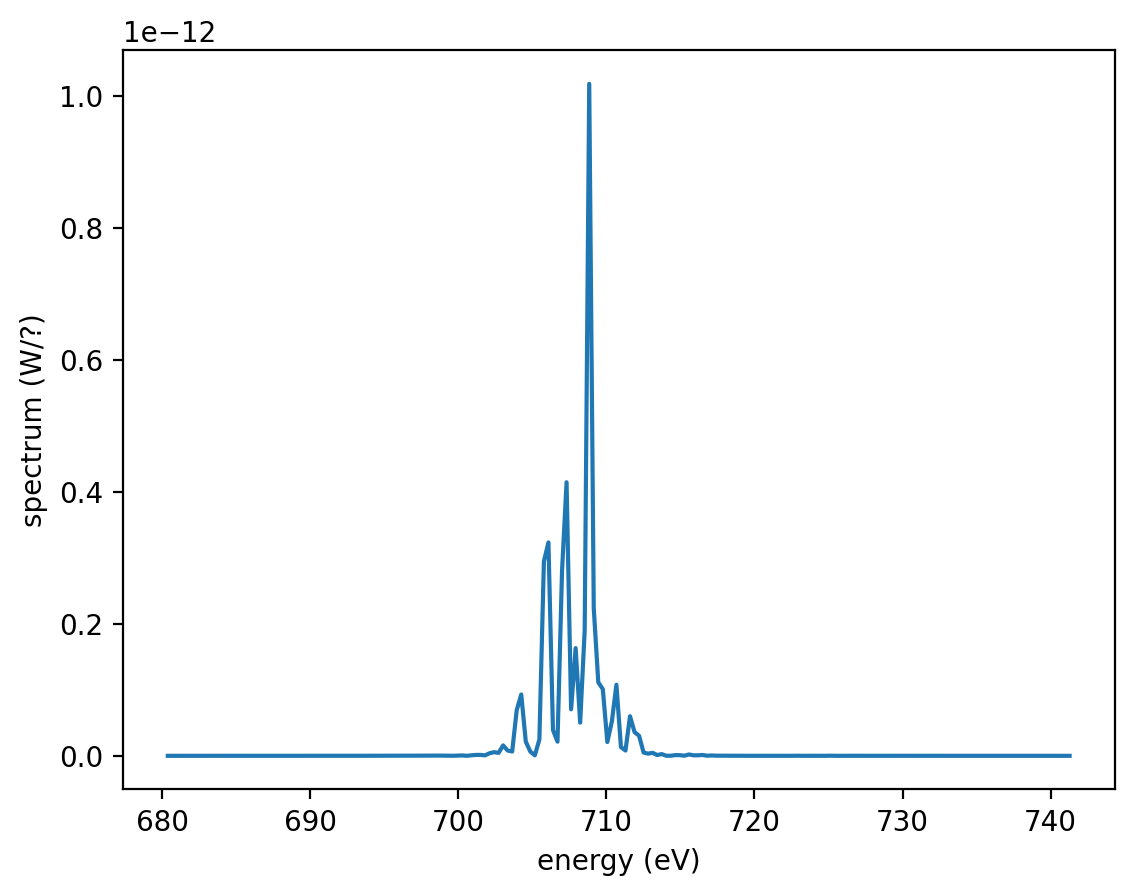

In [13]:
# plot spectrum
freq = output['freq']
spectrum = output['spectrum']
plt.plot(freq,spectrum[1:,-1])
plt.xlabel('energy (eV)')
plt.ylabel('spectrum (W/?)')

# Particle history of final slice

In [14]:
theta = output['theta_final_slice_history']
eta = output['eta_final_slice_history']
_, n_step = theta.shape

# particles, step along z
theta.shape

(512, 201)

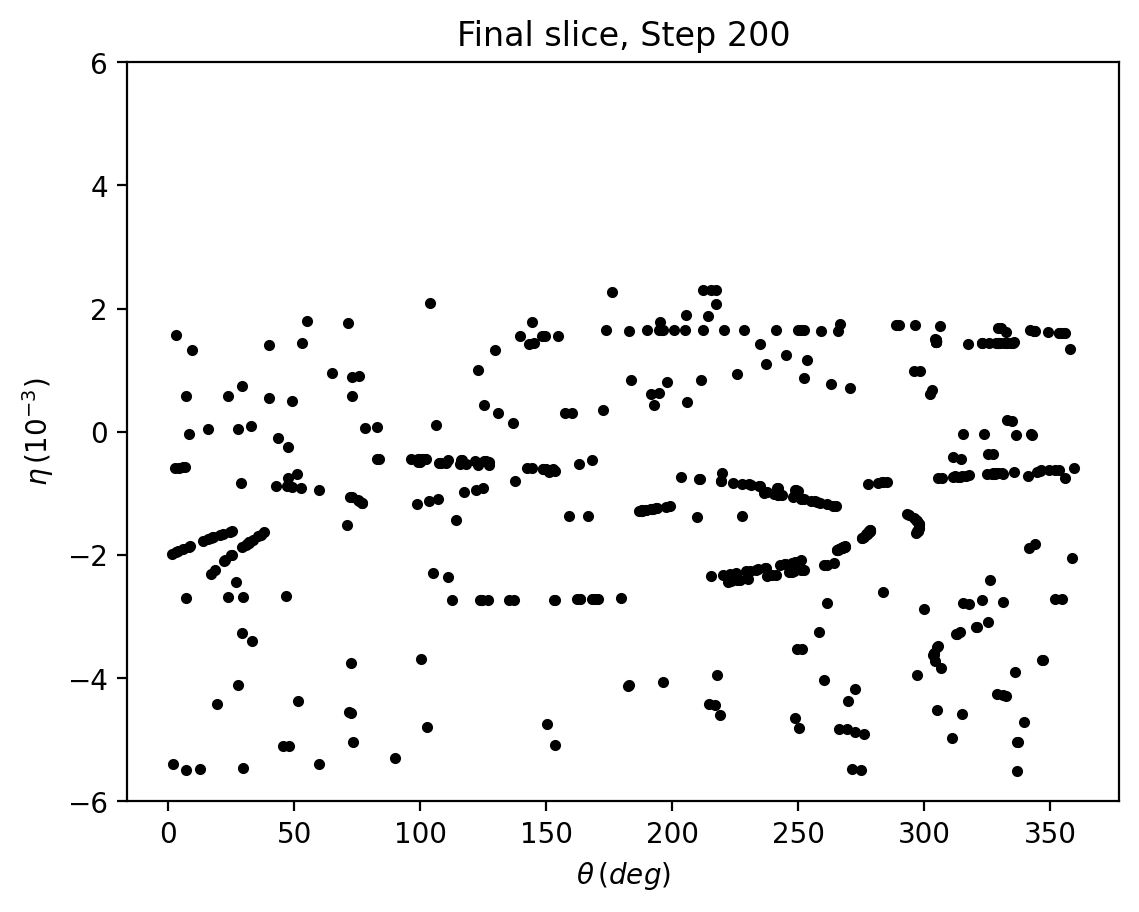

In [15]:
# Function to plot a single step
def plot_step(i):
    
    x = (theta[:,i] % 2*np.pi)/(2*np.pi) * 360
    y = eta[:,i]*1e3
    
    fig, ax = plt.subplots()
    
    ax.set_title(f'Final slice, Step {i}')
    ax.set_ylim(-6,6)
    ax.set_xlabel(r'$\theta\, (deg)$')
    ax.set_ylabel(r'$ \eta\, (10^{-3})$')
    ax.scatter(x, y, marker='.', color='black')

plot_step(n_step-1)

In [ ]:
# interactive
#from ipywidgets import interact
#import ipywidgets as widgets

#interact(plot_step, i=widgets.IntSlider(min=0, max=n_step-1, step=1, value=n_step//2));